In [6]:
import numpy as np
import pandas as pd
import datetime
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [7]:
df_train = pd.read_csv('../input/train_20190217.csv')
df_test = pd.read_csv('../input/test_201917.csv')

df_train = df_train[df_train.target > -30].reset_index(drop=True)

In [8]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [9]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_count_merchants_of_zero_target.csv")

In [10]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [11]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.95:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_purchase_amount_sum】 --- 【hist_purchase_amount_max】
0.999985926602475



【hist_purchase_amount_sum】 --- 【hist_purchase_amount_mean】
0.9962033786137642



【hist_purchase_amount_sum】 --- 【hist_purchase_amount_var】
0.9947122063674376



【hist_purchase_amount_max】 --- 【hist_purchase_amount_mean】
0.9962419985855848



【hist_purchase_amount_max】 --- 【hist_purchase_amount_var】
0.9947527704423479



【hist_purchase_amount_mean】 --- 【hist_purchase_amount_var】
0.999580117903035



【hist_month_diff_mean】 --- 【hist_purchase_date_uptonow】
0.9572702909205548



【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9947393603861712



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9936737901353109



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979568046035838



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979568046035838



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9869741348004349



【hist_category_1_sum】 --- 【category_1_true】
0.99

In [12]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',  #auc
    "lambda_l1": 0.7296012043929662,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65212	valid_1's rmse: 1.65164
[200]	training's rmse: 1.61631	valid_1's rmse: 1.6162
[300]	training's rmse: 1.59533	valid_1's rmse: 1.59603
[400]	training's rmse: 1.58181	valid_1's rmse: 1.58375
[500]	training's rmse: 1.57229	valid_1's rmse: 1.5758
[600]	training's rmse: 1.565	valid_1's rmse: 1.57026
[700]	training's rmse: 1.55918	valid_1's rmse: 1.56632
[800]	training's rmse: 1.55428	valid_1's rmse: 1.56334
[900]	training's rmse: 1.55003	valid_1's rmse: 1.56099
[1000]	training's rmse: 1.5462	valid_1's rmse: 1.55908
[1100]	training's rmse: 1.54266	valid_1's rmse: 1.55758
[1200]	training's rmse: 1.53946	valid_1's rmse: 1.55632
[1300]	training's rmse: 1.53646	valid_1's rmse: 1.55528
[1400]	training's rmse: 1.53367	valid_1's rmse: 1.55447
[1500]	training's rmse: 1.531	valid_1's rmse: 1.55369
[1600]	training's rmse: 1.52843	valid_1's rmse: 1.55309
[1700]	training's rmse: 1.52599	valid_1's rmse: 1.

[8100]	training's rmse: 1.42764	valid_1's rmse: 1.53907
[8200]	training's rmse: 1.42631	valid_1's rmse: 1.53907
[8300]	training's rmse: 1.42495	valid_1's rmse: 1.53907
[8400]	training's rmse: 1.42363	valid_1's rmse: 1.53904
[8500]	training's rmse: 1.42231	valid_1's rmse: 1.53903
[8600]	training's rmse: 1.42097	valid_1's rmse: 1.53902
[8700]	training's rmse: 1.41969	valid_1's rmse: 1.539
[8800]	training's rmse: 1.4184	valid_1's rmse: 1.53899
[8900]	training's rmse: 1.41708	valid_1's rmse: 1.53898
[9000]	training's rmse: 1.4158	valid_1's rmse: 1.53898
[9100]	training's rmse: 1.41451	valid_1's rmse: 1.539
[9200]	training's rmse: 1.41321	valid_1's rmse: 1.53898
Early stopping, best iteration is:
[8881]	training's rmse: 1.41734	valid_1's rmse: 1.53897
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65115	valid_1's rmse: 1.65415
[200]	training's rmse: 1.61508	valid_1's rmse: 1.62006
[300]	training's rmse: 1.59397	valid_1's rmse: 1.60068
[400]	tr

[5100]	training's rmse: 1.46688	valid_1's rmse: 1.55341
[5200]	training's rmse: 1.46539	valid_1's rmse: 1.55333
[5300]	training's rmse: 1.46396	valid_1's rmse: 1.55332
[5400]	training's rmse: 1.46249	valid_1's rmse: 1.55327
[5500]	training's rmse: 1.46103	valid_1's rmse: 1.55322
[5600]	training's rmse: 1.45957	valid_1's rmse: 1.5532
[5700]	training's rmse: 1.45813	valid_1's rmse: 1.55317
[5800]	training's rmse: 1.4567	valid_1's rmse: 1.55312
[5900]	training's rmse: 1.45525	valid_1's rmse: 1.55309
[6000]	training's rmse: 1.45385	valid_1's rmse: 1.55312
[6100]	training's rmse: 1.45245	valid_1's rmse: 1.5531
[6200]	training's rmse: 1.451	valid_1's rmse: 1.55308
[6300]	training's rmse: 1.44953	valid_1's rmse: 1.55305
[6400]	training's rmse: 1.44808	valid_1's rmse: 1.55302
[6500]	training's rmse: 1.44667	valid_1's rmse: 1.55303
[6600]	training's rmse: 1.4453	valid_1's rmse: 1.55302
[6700]	training's rmse: 1.44389	valid_1's rmse: 1.55304
[6800]	training's rmse: 1.44257	valid_1's rmse: 1.5530

1.5534861944234652

In [ ]:
#1.5534861944234652

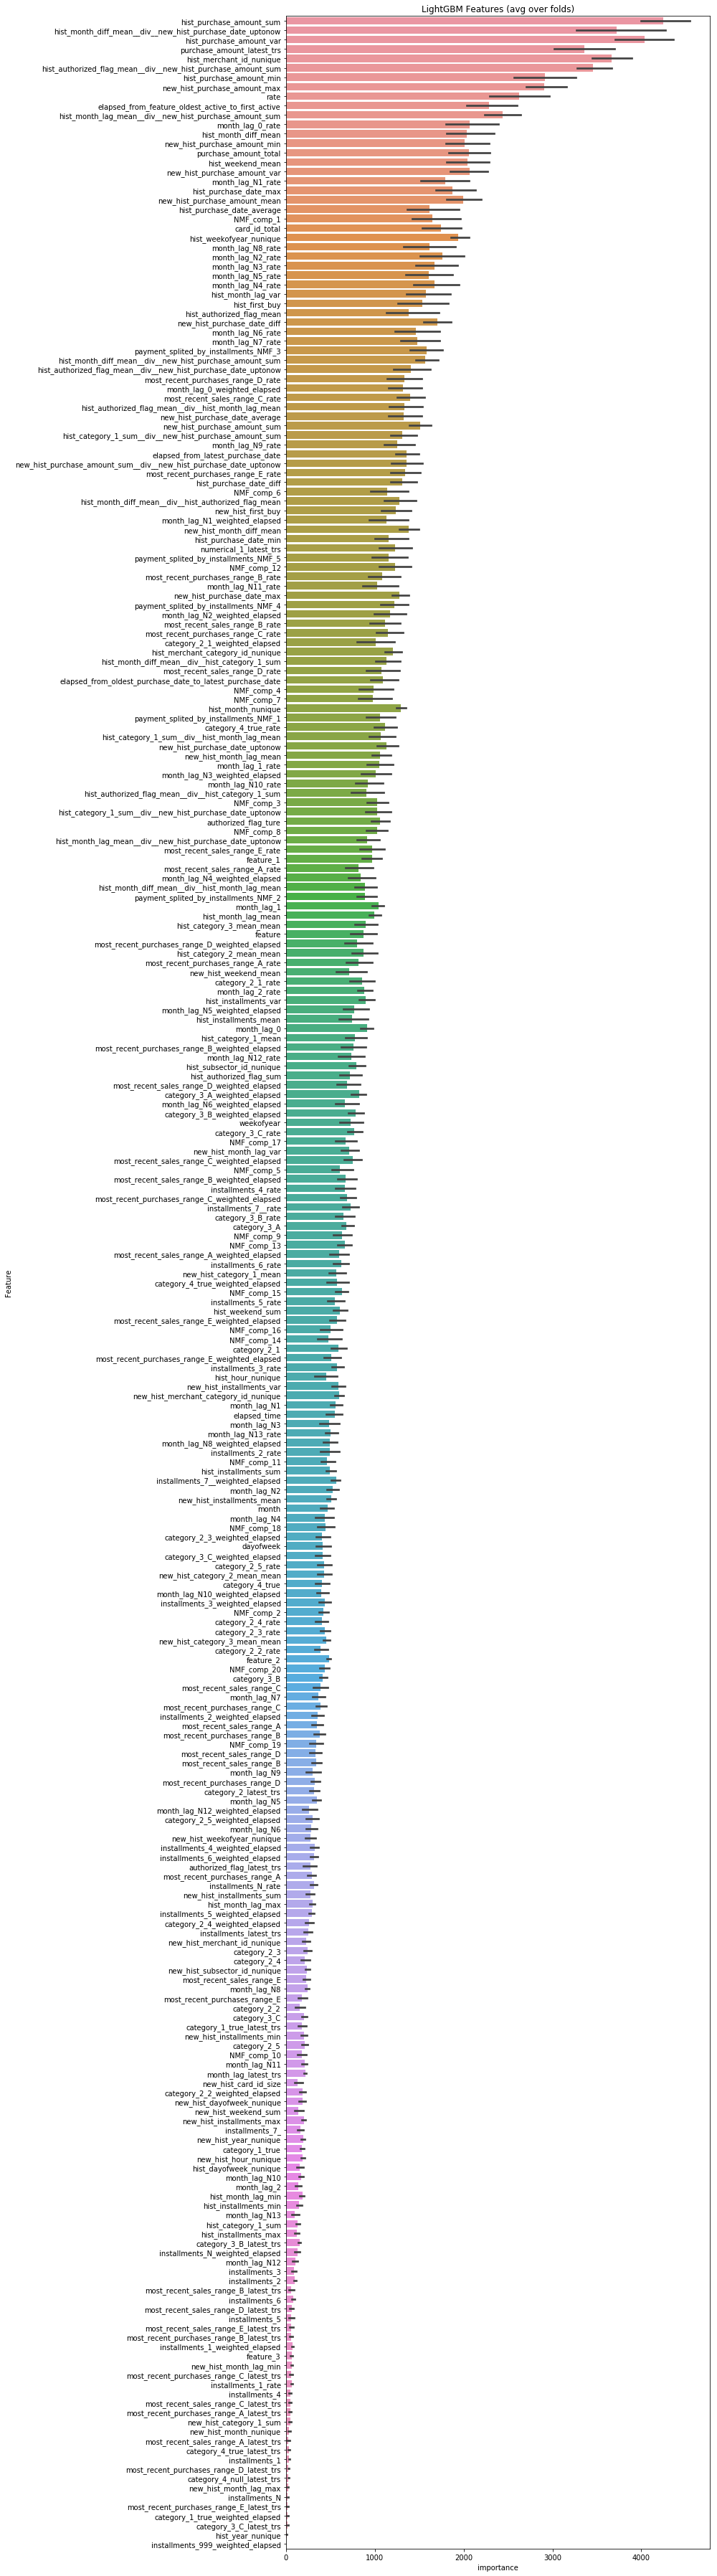

In [13]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [14]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',  #auc
    "lambda_l1": 0.7296012043929662,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.6521	valid_1's rmse: 1.65163
[200]	training's rmse: 1.61632	valid_1's rmse: 1.61626
[300]	training's rmse: 1.59535	valid_1's rmse: 1.5961
[400]	training's rmse: 1.58182	valid_1's rmse: 1.58385
[500]	training's rmse: 1.57232	valid_1's rmse: 1.57588
[600]	training's rmse: 1.56506	valid_1's rmse: 1.57031
[700]	training's rmse: 1.55927	valid_1's rmse: 1.56635
[800]	training's rmse: 1.55443	valid_1's rmse: 1.56344
[900]	training's rmse: 1.5502	valid_1's rmse: 1.56107
[1000]	training's rmse: 1.54639	valid_1's rmse: 1.55915
[1100]	training's rmse: 1.5429	valid_1's rmse: 1.55757
[1200]	training's rmse: 1.5397	valid_1's rmse: 1.55628
[1300]	training's rmse: 1.53672	valid_1's rmse: 1.55519
[1400]	training's rmse: 1.5339	valid_1's rmse: 1.55428
[1500]	training's rmse: 1.53122	valid_1's rmse: 1.55347
[1600]	training's rmse: 1.52869	valid_1's rmse: 1.55285
[1700]	training's rmse: 1.52628	valid_1's rmse: 1

[300]	training's rmse: 1.59396	valid_1's rmse: 1.60065
[400]	training's rmse: 1.58054	valid_1's rmse: 1.58898
[500]	training's rmse: 1.57115	valid_1's rmse: 1.58139
[600]	training's rmse: 1.56395	valid_1's rmse: 1.5762
[700]	training's rmse: 1.55821	valid_1's rmse: 1.57246
[800]	training's rmse: 1.55345	valid_1's rmse: 1.56965
[900]	training's rmse: 1.54924	valid_1's rmse: 1.56737
[1000]	training's rmse: 1.54547	valid_1's rmse: 1.56541
[1100]	training's rmse: 1.54203	valid_1's rmse: 1.56385
[1200]	training's rmse: 1.53892	valid_1's rmse: 1.5626
[1300]	training's rmse: 1.53599	valid_1's rmse: 1.5615
[1400]	training's rmse: 1.53325	valid_1's rmse: 1.56057
[1500]	training's rmse: 1.5306	valid_1's rmse: 1.55973
[1600]	training's rmse: 1.52819	valid_1's rmse: 1.55912
[1700]	training's rmse: 1.5258	valid_1's rmse: 1.55851
[1800]	training's rmse: 1.52354	valid_1's rmse: 1.55804
[1900]	training's rmse: 1.52134	valid_1's rmse: 1.55762
[2000]	training's rmse: 1.51921	valid_1's rmse: 1.55723
[210

[7700]	training's rmse: 1.43016	valid_1's rmse: 1.55295
[7800]	training's rmse: 1.42882	valid_1's rmse: 1.55296
[7900]	training's rmse: 1.42749	valid_1's rmse: 1.55296
[8000]	training's rmse: 1.42616	valid_1's rmse: 1.55296
[8100]	training's rmse: 1.4248	valid_1's rmse: 1.55297
[8200]	training's rmse: 1.42344	valid_1's rmse: 1.553
[8300]	training's rmse: 1.42209	valid_1's rmse: 1.55297
Early stopping, best iteration is:
[7933]	training's rmse: 1.42703	valid_1's rmse: 1.55293
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.64648	valid_1's rmse: 1.67355
[200]	training's rmse: 1.61044	valid_1's rmse: 1.63918
[300]	training's rmse: 1.58943	valid_1's rmse: 1.62
[400]	training's rmse: 1.57598	valid_1's rmse: 1.60828
[500]	training's rmse: 1.56651	valid_1's rmse: 1.60051
[600]	training's rmse: 1.55926	valid_1's rmse: 1.59509
[700]	training's rmse: 1.55348	valid_1's rmse: 1.59111
[800]	training's rmse: 1.54869	valid_1's rmse: 1.58821
[900]	trainin

1.553465840708673

In [ ]:
#1.553465840708673

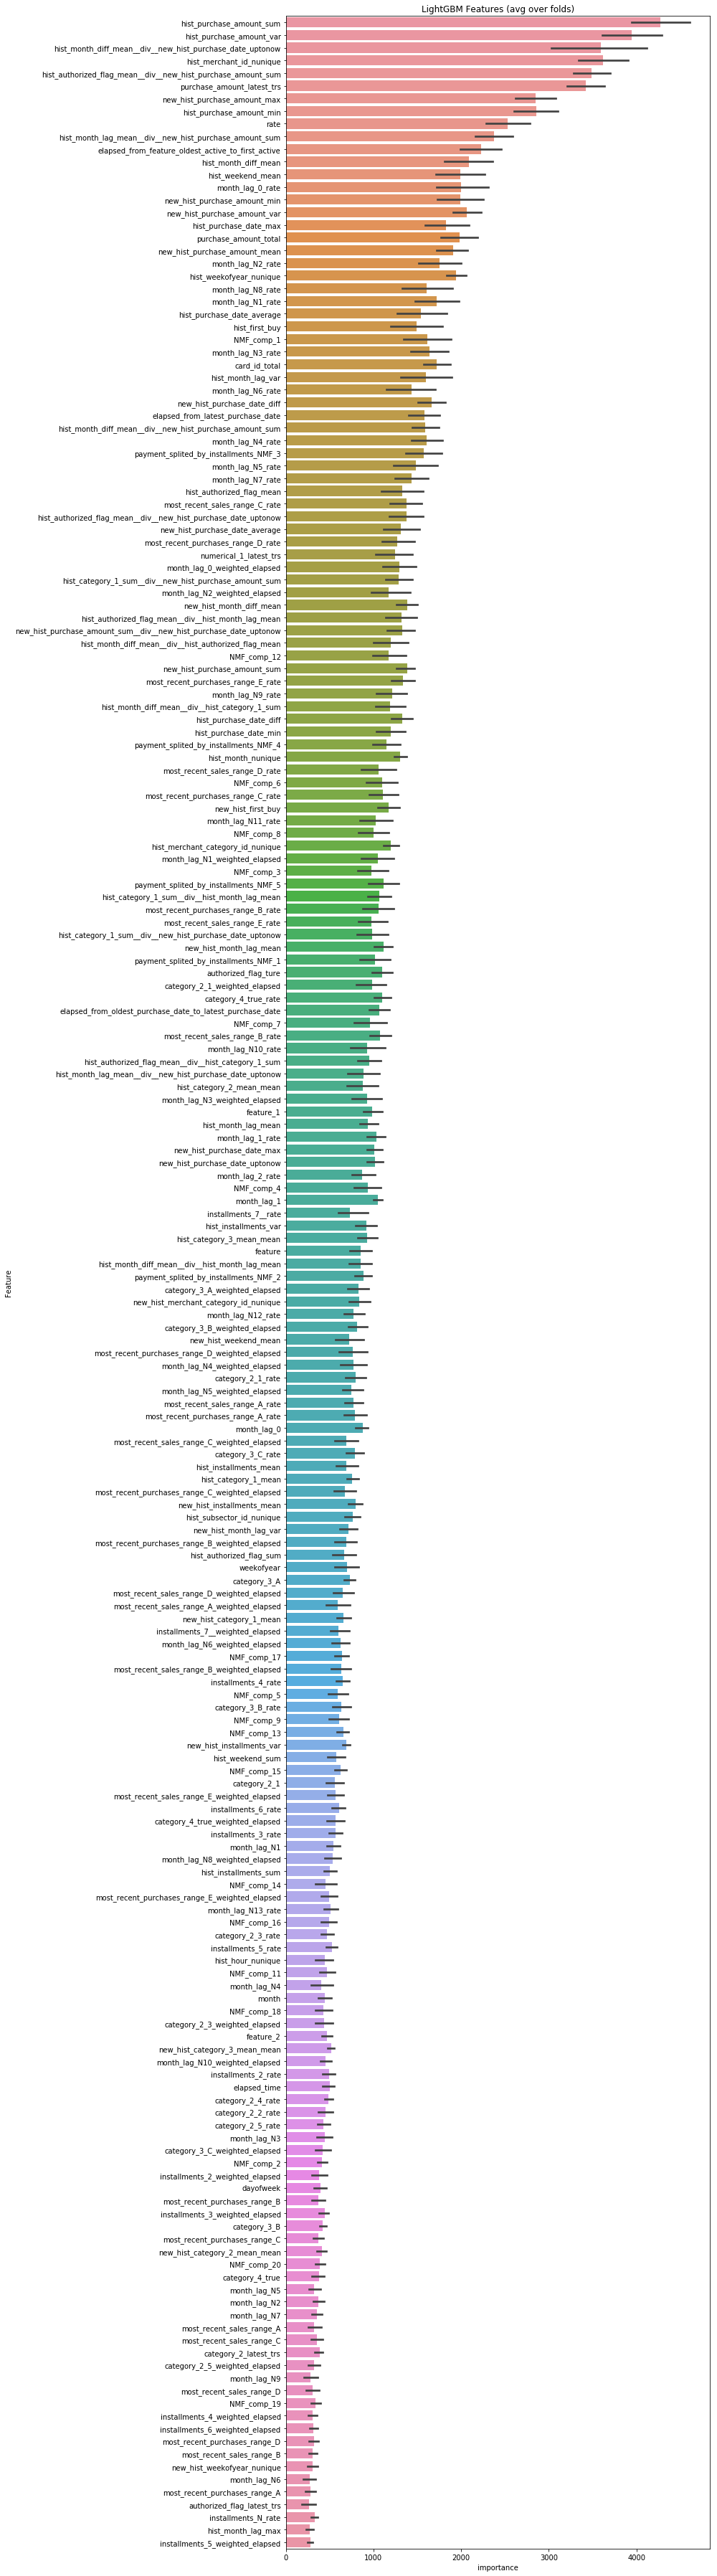

In [15]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [17]:
submission = pd.DataFrame({"card_id":df_test.card_id, "target":predictions})

In [18]:
submission.to_csv("../output/submission_no_outliers_model20190217.csv", index=False)